In [1]:
import pandas as pd
import numpy as np

In [2]:
import zipfile
import tensorflow as tf
import sys

In [3]:
import checkmate
from checkmate import BestCheckpointSaver

In [4]:
import matplotlib.pyplot as plt

In [5]:
seq_len = None

In [6]:
def remove_outliers(data, threshold=73):
    titles = {i: i.lower() for i in data.columns}
    return (data.rename(columns=titles).query('expected <= @threshold').copy())

In [7]:
def seq_pad(data, size, steps):
    arr = []
    for i in data:
        _ = i.copy()
        _.resize(steps, size)
        arr.append(_)
    arr = np.array(arr)
    return arr

# Data Loading

training - 20 days of each month
test - remaining days
Both sets are independent
Calendar time and location information omitted:
    impossible to construct a local validation holdout subset independent from the rest of the training set
    no way to ensure that any two gauge readings are not correlated in time/space

In [8]:
#zf1 = zipfile.ZipFile('../../train.zip')
#zf2 = zipfile.ZipFile('../../test.zip')
#train = pd.read_csv(zf1.open(zipfile.ZipFile.namelist(zf1)[0]))
#test = pd.read_csv(zf2.open(zipfile.ZipFile.namelist(zf2)[0]))
train = pd.read_csv('../../train.csv', nrows=60000).pipe(remove_outliers)
test = pd.read_csv('../../test.csv', nrows=50000)

In [9]:
train.head()

,id,minutes_past,radardist_km,ref,ref_5x5_10th,ref_5x5_50th,ref_5x5_90th,refcomposite,refcomposite_5x5_10th,refcomposite_5x5_50th,...,rhohv_5x5_90th,zdr,zdr_5x5_10th,zdr_5x5_50th,zdr_5x5_90th,kdp,kdp_5x5_10th,kdp_5x5_50th,kdp_5x5_90th,expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254


In [10]:
train_t = train.copy()

5-layer deep stacked Bi-RNN, 64-256 hidden units, dense after each hidden stack, 
last layer at each time position vector is fed into a dense layer with 1 output and ReLU. Take mean of the predictions from the entire top layer


# Preprocessing
exclude the rain gauges with readings above 70mm.
replace missing radar feature values with zero
each timestamp as a component in the feature vector, sequential nature of the input is preserved

In [11]:
#train_t['count_id'] = train_t.groupby('Id')['Id'].transform('count')
#train_t['count_None_Ref'] = train_t[~np.isnan(train_t.Ref)].transform('count')
train_nones = train_t[~np.isnan(train_t['ref'])]['id'].unique()
train_full = train_t['id']

In [12]:
train_cleaned = train_t[np.in1d(train_full, train_nones)].fillna(0.0).reset_index(drop=True)

In [13]:
ids = train_cleaned['id'].unique()
train_ids = np.random.choice(ids,
                               size=np.ceil(len(ids) * (9/10.)).astype(int),
                               replace=False)

In [14]:
train_data = train_cleaned.loc[train_cleaned['id'].isin(train_ids)]
val_data = train_cleaned.loc[~train_cleaned['id'].isin(train_ids)]
#[train.columns != 'expected']

In [15]:
train_data.head()

,id,minutes_past,radardist_km,ref,ref_5x5_10th,ref_5x5_50th,ref_5x5_90th,refcomposite,refcomposite_5x5_10th,refcomposite_5x5_50th,...,rhohv_5x5_90th,zdr,zdr_5x5_10th,zdr_5x5_50th,zdr_5x5_90th,kdp,kdp_5x5_10th,kdp_5x5_50th,kdp_5x5_90th,expected
0,2,1,2.0,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016
1,2,6,2.0,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,0.000000,0.000000,0.000000,1.409988,1.016
2,2,11,2.0,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,0.000000,-0.350006,1.759994,1.016
3,2,16,2.0,18.0,14.0,17.5,21.0,20.5,18.0,20.5,...,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016
4,2,21,2.0,24.5,16.5,21.0,24.5,24.5,21.0,24.0,...,0.998333,0.2500,0.0625,0.1875,0.5625,-0.350006,-1.059998,-0.350006,1.759994,1.016


In [16]:
y_train = train_data.groupby('id')['expected'].last().values

y_val = val_data.groupby('id')['expected'].last().values

In [17]:
train_data = train_data.drop('expected', 1).fillna(0.0)
val_data = val_data.drop('expected', 1).fillna(0.0)

In [18]:
train_data_arr = train_data.groupby('id').apply(lambda x: x.values.astype('float')).values
val_data_arr = val_data.groupby('id').apply(lambda x: x.values.astype('float')).values

seq_lens_train = train_data.groupby('id').size().values
seq_lens_val = val_data.groupby('id').size().values

In [19]:
seq_lens_train[:10]

array([12, 15, 12, 12,  7, 10, 12, 12, 10, 15])

In [20]:
train_data_arr.shape, y_train.shape, val_data_arr.shape, y_val.shape 

((2837,), (2837,), (315,), (315,))

In [21]:
train_data_arr.shape[0], train_data_arr[0].shape[0], train_data_arr[0].shape[1]

(2837, 12, 23)

In [22]:
seq_len = max([seq_lens_train.max(), seq_lens_val.max()])#choose the length of the sequence
neurons = [32, 64, 128, 256, 500]
n_in = train_data_arr[0].shape[1]#length of the feature vector of each element in a sequence
n_out = 1#dim of the output feture vector

In [23]:
val_pad = seq_pad(val_data_arr, n_in, seq_len)

### Creating the RNN Model

#### RNN-LSTM 1. Two Layers.

In this step we are building the RNN model that consists of two layers of LSTM stacked on top of the other. Also, we add a droput to overcome the overfitting.

We have experimented with different number of neurons in different layers, with the number of units > 64 the model is quite complex, what results in a huge overfitteing

In [82]:
tf.reset_default_graph()

In [83]:
X = tf.placeholder(dtype=tf.float32, shape=[None, seq_len , n_in])
y = tf.placeholder(tf.float32, [None])
seq_length = tf.placeholder(dtype=tf.int16, shape=[None])

with tf.variable_scope('lstm-rnn', initializer=tf.contrib.layers.variance_scaling_initializer()):
    rnn_cell_1 = tf.contrib.rnn.LSTMCell(num_units=neurons[0])
    rnn_cell_2 = tf.contrib.rnn.LSTMCell(num_units=neurons[1])
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell([rnn_cell_1, rnn_cell_2])
    outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32,
                                        sequence_length=seq_length)
    drop = tf.layers.dropout(inputs=states[1], rate=0.4)
    y_pred = tf.layers.dense(drop, n_out)

In [84]:
learning_rate = 0.05

error = (y-y_pred)
loss = tf.reduce_mean(tf.square(error), name="loss")
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
minimizer = optimizer.minimize(loss, global_step=global_step)
minimizer_val = optimizer.minimize(loss, global_step=global_step)

mae = tf.reduce_mean(tf.abs(error))

checkpoint_dir = './models/'
best_ckpt_saver = BestCheckpointSaver(save_dir=checkpoint_dir, num_to_keep=3, maximize=False)

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
n_samples = train_data_arr.shape[0]
n_epochs = 100
batch_size = len(train_data_arr) / 25
#printbatch_size
loss_hist = {'mae': {'train': [], 'val': []}, 'loss':{'train':[], 'val':[]}}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rand_idx = np.random.permutation(np.arange(n_samples))
        train_loss_list = []
        train_mae_list = []
        for batch_i in range(int(n_samples // batch_size)):
            batch_idx = rand_idx[int(batch_i*batch_size):int((batch_i+1)*batch_size)]
            X_batch = seq_pad(train_data_arr[batch_idx], n_in, seq_len)
            y_batch = y_train[batch_idx]
            len_batch = seq_lens_train[batch_idx]
            loss_train, _, step = sess.run(
                    [loss, minimizer, global_step],
                    feed_dict={X: X_batch, seq_length: len_batch, y: y_batch})
            mae_train = mae.eval(feed_dict={X: X_batch, seq_length: len_batch, y: y_batch})
            train_mae_list.append(float(mae_train))
            train_loss_list.append(loss_train)
        
        print("\n")
        
        loss_train_mean = float(np.array(train_loss_list).mean())
        mae_train_mean = float(np.array(train_mae_list).mean())
        
        
        loss_hist['loss']['train'].append(loss_train_mean)
        loss_hist['mae']['train'].append(mae_train_mean)
        
        loss_val, step = sess.run(
                    [loss, global_step],
                    feed_dict={X: val_pad, seq_length: seq_lens_val, y: y_val})
        loss_hist['loss']['val'].append(loss_val)
        
        mae_val = mae.eval(feed_dict={X: val_pad, seq_length: seq_lens_val, y: y_val})
        loss_hist['mae']['val'].append(float(mae_val))
        
        print("{:4d}  Train loss: {:.4f}, Train MAE: {:.2f}  Val MAE: {:.2f}".format(
                epoch, loss_train_mean, mae_train_mean, mae_val))
        
        best_ckpt_saver.handle(loss_val, sess, global_step)
            #saver.save(sess, "./models/model1.ckpt")
        #final_pred = y_pred.eval({X: val_pad, seq_length: seq_lens_val, y: y_test})



   0  Train loss: 69.2343, Train MAE: 3.89  Val MAE: 3.45


   1  Train loss: 35.2518, Train MAE: 3.10  Val MAE: 3.14


   2  Train loss: 35.1551, Train MAE: 3.06  Val MAE: 3.61


   3  Train loss: 33.2832, Train MAE: 3.06  Val MAE: 3.25


   4  Train loss: 35.7425, Train MAE: 3.07  Val MAE: 3.11


   5  Train loss: 35.7073, Train MAE: 3.08  Val MAE: 3.34


   6  Train loss: 35.2486, Train MAE: 3.10  Val MAE: 3.22


   7  Train loss: 32.4737, Train MAE: 2.96  Val MAE: 3.41


   8  Train loss: 35.9325, Train MAE: 3.10  Val MAE: 3.29


   9  Train loss: 30.2344, Train MAE: 3.02  Val MAE: 3.23


  10  Train loss: 34.3673, Train MAE: 3.05  Val MAE: 3.26


  11  Train loss: 34.2686, Train MAE: 3.03  Val MAE: 3.58


  12  Train loss: 35.2840, Train MAE: 3.06  Val MAE: 3.54


  13  Train loss: 33.3282, Train MAE: 3.08  Val MAE: 3.31


  14  Train loss: 34.6201, Train MAE: 3.09  Val MAE: 3.56


  15  Train loss: 35.1186, Train MAE: 3.04  Val MAE: 3.48


  16  Train loss: 36.0727, Train MAE: 

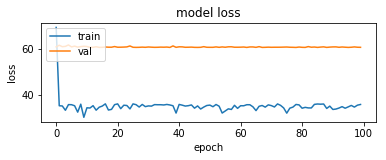

In [87]:
plt.figure(1)

#history of accuracy
plt.subplot(211)
plt.plot(loss_hist['loss']['train'])
plt.plot(loss_hist['loss']['val'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')

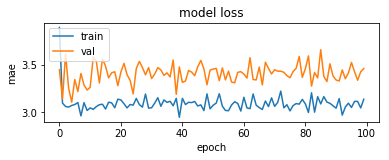

In [89]:
plt.figure(1)

#history of accuracy
plt.subplot(211)
plt.plot(loss_hist['mae']['train'])
plt.plot(loss_hist['mae']['val'])
plt.title('model loss')
plt.ylabel('mae')
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')

#### RNN-BiLSTM 2. 4 Layers

We decided to enchance our model. We changed one directional LSTMS to Bidirectional and increased the number of layers on 4.

We have experimented with different number of layers and neurons.

In [90]:
tf.reset_default_graph()

In [91]:
X = tf.placeholder(dtype=tf.float32, shape=[None, seq_len , n_in])
y = tf.placeholder(tf.float32, [None])
seq_length = tf.placeholder(dtype=tf.int16, shape=[None])
num_layers = [64, 64, 128, 128, 256]
with tf.variable_scope('lstm-rnn2', initializer=tf.contrib.layers.variance_scaling_initializer()):

    num_layers = 4
    num_nodes = 128


    # Define LSTM cells
    enc_fw_cells = [tf.contrib.rnn.LSTMCell(num_nodes)for layer in range(num_layers)]
    enc_bw_cells = [tf.contrib.rnn.LSTMCell(num_nodes) for layer in range(num_layers)]

    # Connect LSTM cells bidirectionally and stack
    (all_states, fw_state, bw_state) = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
            cells_fw=enc_fw_cells, cells_bw=enc_bw_cells, inputs=X, dtype=tf.float32)

    # Concatenate results
    for k in range(num_layers):
        if k == 0:
            con_c = tf.concat((fw_state[k].c, bw_state[k].c), 1)
            con_h = tf.concat((fw_state[k].h, bw_state[k].h), 1)
        else:
            con_c = tf.concat((con_c, fw_state[k].c, bw_state[k].c), 1)
            con_h = tf.concat((con_h, fw_state[k].h, bw_state[k].h), 1)

    output = tf.contrib.rnn.LSTMStateTuple(c=con_c, h=con_h)
    drop = tf.layers.dropout(inputs=all_states[7], rate=0.4)
    y_pred = tf.layers.dense(drop, n_out)

In [92]:
learning_rate = 0.05

error = (y-y_pred)
loss = tf.reduce_mean(tf.square(error), name="loss")
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
minimizer = optimizer.minimize(loss, global_step=global_step)
minimizer_val = optimizer.minimize(loss, global_step=global_step)

mae = tf.reduce_mean(tf.abs(error))

checkpoint_dir = './models/'
best_ckpt_saver = BestCheckpointSaver(save_dir=checkpoint_dir, num_to_keep=3, maximize=False)

In [93]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_samples = train_data_arr.shape[0]
n_epochs = 50
batch_size = len(train_data_arr) / 25
#printbatch_size
loss_hist = {'mae': {'train': [], 'val': []}, 'loss':{'train':[], 'val':[]}}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rand_idx = np.random.permutation(np.arange(n_samples))
        train_loss_list = []
        train_mae_list = []
        for batch_i in range(int(n_samples // batch_size)):
            batch_idx = rand_idx[int(batch_i*batch_size):int((batch_i+1)*batch_size)]
            X_batch = seq_pad(train_data_arr[batch_idx], n_in, seq_len)
            y_batch = y_train[batch_idx]
            len_batch = seq_lens_train[batch_idx]
            loss_train, _, step = sess.run(
                    [loss, minimizer, global_step],
                    feed_dict={X: X_batch, seq_length: len_batch, y: y_batch})
            mae_train = mae.eval(feed_dict={X: X_batch, seq_length: len_batch, y: y_batch})
            train_mae_list.append(float(mae_train))
            train_loss_list.append(loss_train)
        
        print("\n")
        
        loss_train_mean = float(np.array(train_loss_list).mean())
        mae_train_mean = float(np.array(train_mae_list).mean())
        
        
        loss_hist['loss']['train'].append(loss_train_mean)
        loss_hist['mae']['train'].append(mae_train_mean)
        
        loss_val, step = sess.run(
                    [loss, global_step],
                    feed_dict={X: val_pad, seq_length: seq_lens_val, y: y_val})
        loss_hist['loss']['val'].append(loss_val)
        
        mae_val = mae.eval(feed_dict={X: val_pad, seq_length: seq_lens_val, y: y_val})
        loss_hist['mae']['val'].append(float(mae_val))
        
        print("{:4d}  Train loss: {:.4f}, Train MAE: {:.2f}  Val MAE: {:.2f}".format(
                epoch, loss_train_mean, mae_train_mean, mae_val))
        
        best_ckpt_saver.handle(loss_val, sess, global_step)
            #saver.save(sess, "./models/model1.ckpt")
        #final_pred = y_pred.eval({X: val_pad, seq_length: seq_lens_val, y: y_test})



   0  Train loss: 42.6806, Train MAE: 3.64  Val MAE: 3.19


   1  Train loss: 35.8993, Train MAE: 3.17  Val MAE: 3.24


   2  Train loss: 33.9734, Train MAE: 3.06  Val MAE: 3.24


   3  Train loss: 33.6160, Train MAE: 3.10  Val MAE: 3.60


   4  Train loss: 35.2235, Train MAE: 3.07  Val MAE: 3.39


   5  Train loss: 36.3563, Train MAE: 3.17  Val MAE: 3.11


   6  Train loss: 35.6056, Train MAE: 3.15  Val MAE: 2.98


As we can see from the plots from the first epochs the loss drops dramatically, and on the further steps it is mostly constant. That happens due to model trapping in the local minima.

In [ ]:
plt.figure(1)

#history of accuracy
plt.subplot(211)
plt.plot(loss_hist['loss']['train'])
plt.plot(loss_hist['loss']['val'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
plt.figure(1)

#history of accuracy
plt.subplot(211)
plt.plot(loss_hist['mae']['train'])
plt.plot(loss_hist['mae']['val'])
plt.title('model loss')
plt.ylabel('mae')
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')

## Test the model

In [59]:
test_nones = test[~np.isnan(test['Ref'])]['Id'].unique()
test_full = test['Id']
test_cleaned = test[np.in1d(test_full, test_nones)].fillna(0.0).reset_index(drop=True)

test_data_arr = test_cleaned.groupby('Id').apply(lambda x: x.values.astype('float')).values
test_pad = seq_pad(test_data_arr, n_in, seq_len)

In [60]:
#tf.reset_default_graph()

In [62]:
sess = tf.InteractiveSession()

In [63]:
tf.train.Saver().restore(sess, checkmate.get_best_checkpoint(checkpoint_dir, select_maximum_value=False))

INFO:tensorflow:Restoring parameters from ./models/best.ckpt-5


InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [32,1] rhs shape= [64,1]
	 [[Node: save_2/Assign_6 = Assign[T=DT_FLOAT, _class=["loc:@lstm-rnn/dense/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](lstm-rnn/dense/kernel, save_2/RestoreV2:6)]]

Caused by op 'save_2/Assign_6', defined at:
  File "/home/gazizullina149/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/gazizullina149/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/gazizullina149/anaconda3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/gazizullina149/anaconda3/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/gazizullina149/anaconda3/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-63-c808d3833331>", line 1, in <module>
    tf.train.Saver().restore(sess, checkmate.get_best_checkpoint(checkpoint_dir, select_maximum_value=False))
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 112, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 216, in assign
    validate_shape=validate_shape)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/gazizullina149/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [32,1] rhs shape= [64,1]
	 [[Node: save_2/Assign_6 = Assign[T=DT_FLOAT, _class=["loc:@lstm-rnn/dense/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](lstm-rnn/dense/kernel, save_2/RestoreV2:6)]]


In [40]:
pred = y_pred.eval({X: test_pad, seq_length: test_lens, y: y_test})
np.abs((pred - y_test)).argmin()

NameError: name 'test_pad' is not defined